# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**Julian Vargo

*Semester:* Fall 2025

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

## I was able to get my code working by importing keras via tensorflow.
## Uncomment this code, and comment out the 'from tensorflow' lines
## if the 'from keras' lines work fine for you while grading
    # from keras.models import Sequential
    # from keras.layers import Dense, Dropout
    # import keras
    # from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

np.random.seed(10)

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

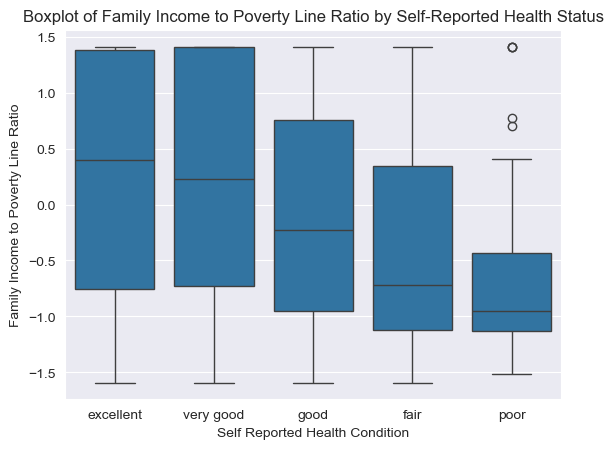

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

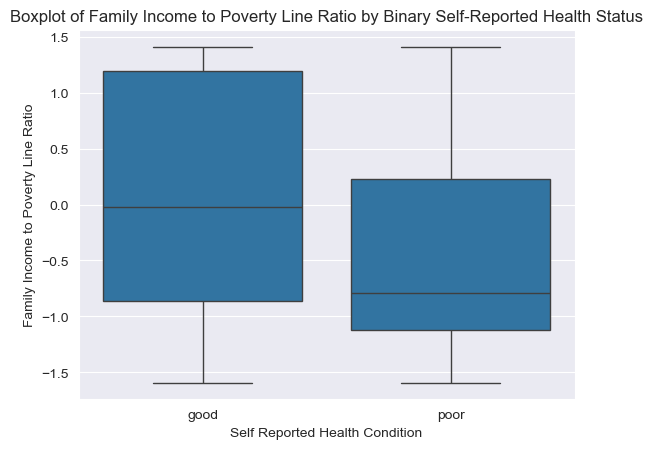

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

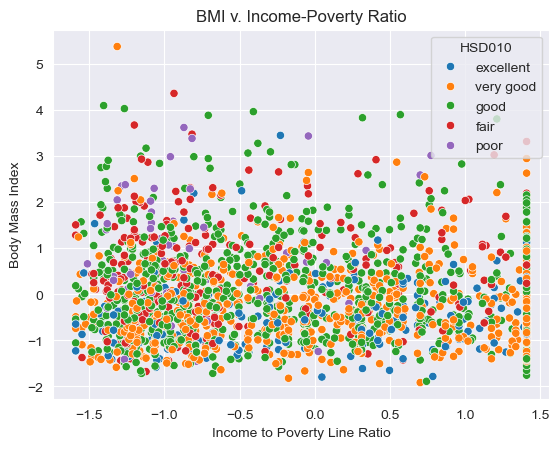

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
# I'm saving the full dataset for troubleshooting so I can easily call this df when I need it
nhanes_scaled_full = nhanes_scaled
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

Variance per PC: [0.10201961 0.07623011 0.04371192 0.02882172 0.02357132 0.0190163
 0.01810852 0.01655591 0.0155711  0.01532196 0.01319954 0.01212683
 0.01157877 0.01155923 0.01109711 0.01004274 0.0094175  0.00930795
 0.00878108 0.0086428 ]

Cumulative Variance: [0.10201961 0.17824972 0.22196164 0.25078336 0.27435468 0.29337098
 0.3114795  0.32803541 0.34360651 0.35892847 0.37212801 0.38425484
 0.39583361 0.40739283 0.41848994 0.42853269 0.43795019 0.44725814
 0.45603922 0.46468202]



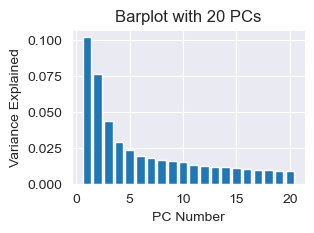

How many components will you use to fit a supervised learning model?

I use 5 principal components, which I got from looking at where variance gain drops off in a scree plot. 
This is because I want to capture most of the variance in the data while
keeping the model interpretable.



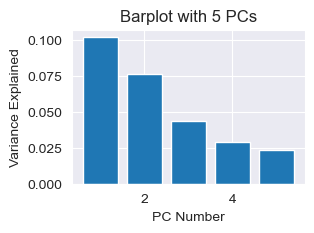

Final PCA variance explained from PC1-5: [0.10201961 0.07623011 0.04371192 0.02882171 0.0235713 ]


,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,9.527811,-0.816225,1.867044,-2.110598,3.929579
1,-5.838338,-3.692573,-3.805746,-1.029526,-0.394717
2,-0.719454,-2.573199,-0.907948,-4.753721,1.796932
3,3.533627,-2.576984,3.249112,-0.408297,-3.998555
4,-6.872094,-4.194239,-0.886874,-0.847723,0.521333


In [7]:
# I fit my first PCA by arbitrarily selecting 10 PCs to start out
number_of_pcs = 20
pca = PCA(n_components = number_of_pcs)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

# These two lines tell us how much variance each PC explains
# And how much cumulative variance all of the PCs explain
print(f"Variance per PC: {pca.explained_variance_ratio_}\n")
print(f"Cumulative Variance: {np.cumsum(pca.explained_variance_ratio_)}\n")

# We can make a small plot to visualize those variance arrays
plt.figure(figsize=(3,2))
plt.bar(range(1, number_of_pcs + 1), pca.explained_variance_ratio_)
plt.xlabel("PC Number")
plt.ylabel("Variance Explained")
plt.title(f"Barplot with {number_of_pcs} PCs")
plt.show()

print("""How many components will you use to fit a supervised learning model?

I use 5 principal components, which I got from looking at where variance gain drops off in a scree plot. 
This is because I want to capture most of the variance in the data while
keeping the model interpretable.
""")

# Rerun a PCA with 5 PCs
number_of_pcs = 5
pca = PCA(n_components = number_of_pcs)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

plt.figure(figsize=(3,2))
plt.bar(range(1, number_of_pcs + 1), pca.explained_variance_ratio_)
plt.xlabel("PC Number")
plt.ylabel("Variance Explained")
plt.title(f"Barplot with {number_of_pcs} PCs")
plt.show()

# These two lines tell us how much variance each PC explains
# And how much cumulative variance all of the PCs explain
print(f"Final PCA variance explained from PC1-5: {pca.explained_variance_ratio_}")

# Create a dataframe from the final PCA model
pca_df = pd.DataFrame(data = principalComponents_nhanes, 
    columns = ['principal component 1','principal component 2','principal component 3', 'principal component 4', 'principal component 5'])

# Print the PCA table for the first few variables from our csv
pca_df.head()


### 2D Scatterplot of the first two components

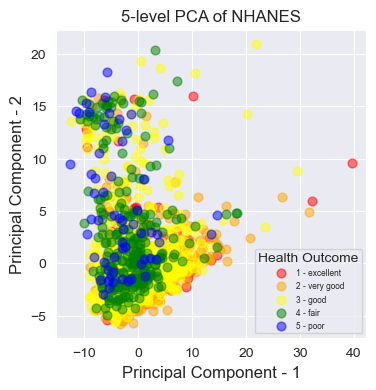

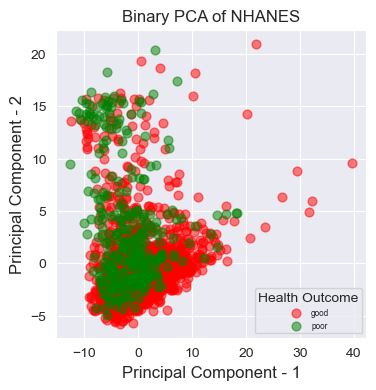


The plots show that poor outcomes are generally found within a more concentrated and interior region of the PCA-transformed data, 
although there is still a great deal of overlap meaning there is not much separability that comes from the PCA.
If someone has high loadings on PC1 or PC2, they are more likely to have better health, 
whereas interior data has a mix of health outcomes.



In [8]:
# Let's add hsd010 back to our df and remap the integers to strings like is done in the earlier plots
label_map = {1:"1 - excellent", 2:"2 - very good", 3:"3 - good", 4:"4 - fair", 5:"5 - poor"}
y = hsd010.map(label_map)
pca_df["label"] = y.values

plt.figure(figsize=(4,4))
plt.xlabel("Principal Component - 1", fontsize=12)
plt.ylabel("Principal Component - 2", fontsize=12)
plt.title("5-level PCA of NHANES", fontsize=12)

targets = pca_df["label"].unique()
colors = ['red', 'orange', 'yellow', 'green', 'blue']

# loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    indicesToKeep = pca_df["label"] == target
    plt.scatter(
        pca_df.loc[indicesToKeep, "principal component 1"],
        pca_df.loc[indicesToKeep, "principal component 2"],
        c=color, s=40, alpha=0.5, label=target
    )

plt.legend(title="Health Outcome", fontsize=6)
plt.show()

#######################
# BINARY VERSION OF PCA 
label_map = {1:"good", 2:"good", 3:"good", 4:"poor", 5:"poor"}
y = hsd010.map(label_map)
pca_df["label"] = y.values

# figure settings
plt.figure(figsize=(4,4))
plt.xlabel("Principal Component - 1", fontsize=12)
plt.ylabel("Principal Component - 2", fontsize=12)
plt.title("Binary PCA of NHANES", fontsize=12)


targets = pca_df["label"].unique()
colors = ['red','green']

# loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    indicesToKeep = pca_df["label"] == target
    plt.scatter(
        pca_df.loc[indicesToKeep, "principal component 1"],
        pca_df.loc[indicesToKeep, "principal component 2"],
        c=color, s=40, alpha=0.5, label=target
    )

plt.legend(title="Health Outcome", fontsize=6)
plt.show()

print("""
The plots show that poor outcomes are generally found within a more concentrated and interior region of the PCA-transformed data, 
although there is still a great deal of overlap meaning there is not much separability that comes from the PCA.
If someone has high loadings on PC1 or PC2, they are more likely to have better health, 
whereas interior data has a mix of health outcomes.
""")

## Clustering

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### K-Means Clustering

In [9]:
print("""
K-Means is an unsupervised clustering algorithm that groups data into a fixed number of groups.
It makes clusters by assigning a datapoint to the nearest group-centroid and then 
iteratively updating the centroids to reduce the data's within-cluster average 
distance between each datapoint and its respective centroid.
""")


K-Means is an unsupervised clustering algorithm that groups data into a fixed number of groups.
It makes clusters by assigning a datapoint to the nearest group-centroid and then 
iteratively updating the centroids to reduce the data's within-cluster average 
distance between each datapoint and its respective centroid.



### Cluster nhanes

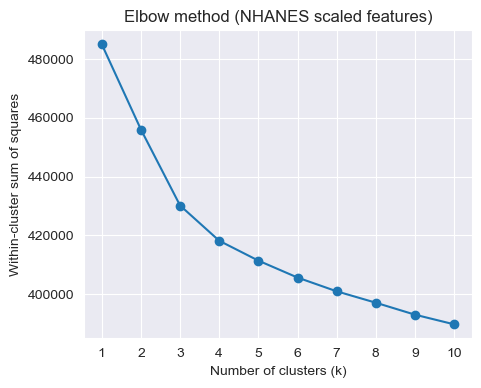

The elbow seems to be around 4 clusters when the k's start to drop off. I'll stick with four clusters


In [10]:
nhanes_scaled_dropped = nhanes_scaled.drop(columns=["HSD010", "HSD010_binary"], errors="ignore")
keep_idx = nhanes_scaled_dropped.dropna().index
nhanes_scaled_dropped = nhanes_scaled_dropped.loc[keep_idx]

number_of_clusters = range(1, 11)
inertias = []

for k in number_of_clusters:
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=0)
    km.fit(nhanes_scaled_dropped)
    inertias.append(km.inertia_)

plt.figure(figsize=(5, 4))
plt.plot(list(number_of_clusters), inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-cluster sum of squares")
plt.title("Elbow method (NHANES scaled features)")
plt.xticks(list(number_of_clusters))
plt.show()

print("""The elbow seems to be around 4 clusters when the k's start to drop off. I'll stick with four clusters""")
k = 4
kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=0).fit(nhanes_scaled_dropped)

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

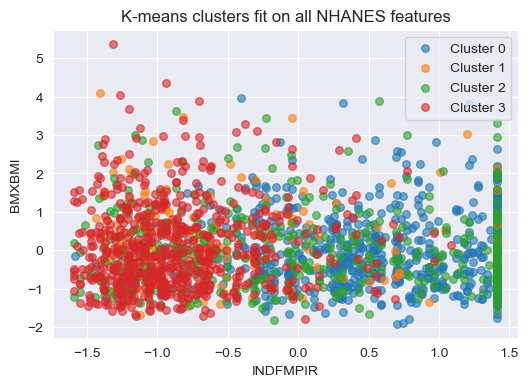

The k-means clusters show some separation of the data, especifically along the INDFMPIR axis,
but overall the clustering algorithm is not able to create a lot of strong separations for the two BMI and poverty axes.



In [11]:
nhanes_plot = nhanes_scaled.loc[keep_idx].copy()
nhanes_plot["cluster"] = kmeans.labels_

plt.figure(figsize=(6, 4))
for cid in range(k):
    m = nhanes_plot["cluster"] == cid
    plt.scatter(
        nhanes_plot.loc[m, "INDFMPIR"],
        nhanes_plot.loc[m, "BMXBMI"],
        s=30, alpha=0.6, label=f"Cluster {cid}"
    )

plt.xlabel("INDFMPIR")
plt.ylabel("BMXBMI")
plt.title("K-means clusters fit on all NHANES features")
plt.legend()
plt.show()

print("""The k-means clusters show some separation of the data, especifically along the INDFMPIR axis,
but overall the clustering algorithm is not able to create a lot of strong separations for the two BMI and poverty axes.
""")

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

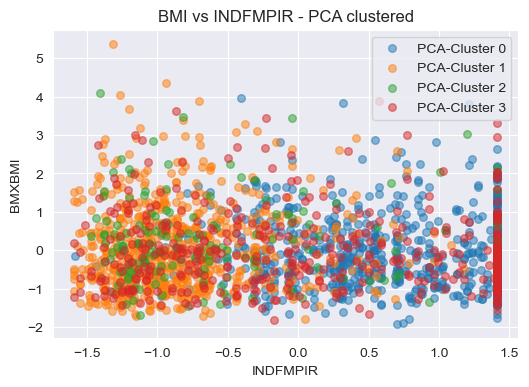

The results show that a kmeans clustering based on a 5PC dataframe sorted data very similarly to the k-means of the raw dataset, with clusters mostly differing on the INDFMPIR axis.
      Nevertheless, both clustering techniques do a fairly poor job at clustering the data if we want to see any separation on the BMI-poverty axes.


In [12]:
X = pca.fit_transform(nhanes_scaled_dropped)

kmeans_pca = KMeans(n_clusters= k, n_init=10, max_iter=300, random_state=0)
labels_pca = kmeans_pca.fit_predict(X)

nhanes_plot_pca = nhanes_scaled.loc[keep_idx].copy()
nhanes_plot_pca["cluster_pca"] = labels_pca

plt.figure(figsize=(6, 4))
for cid in range(k):
    m = nhanes_plot_pca["cluster_pca"] == cid
    plt.scatter(
        nhanes_plot_pca.loc[m, "INDFMPIR"],
        nhanes_plot_pca.loc[m, "BMXBMI"],
        s=30, alpha=0.5, label=f"PCA-Cluster {cid}"
    )

plt.xlabel("INDFMPIR")
plt.ylabel("BMXBMI")
plt.title("BMI vs INDFMPIR - PCA clustered")
plt.legend()
plt.show()

print("""The results show that a kmeans clustering based on a 5PC dataframe sorted data very similarly to the k-means of the raw dataset, with clusters mostly differing on the INDFMPIR axis.
      Nevertheless, both clustering techniques do a fairly poor job at clustering the data if we want to see any separation on the BMI-poverty axes.""")

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [13]:
nhanes_scaled_full['HSD010_binary'] = nhanes_scaled_full['HSD010_binary'].replace({
'good': 1,
'poor': 0
})

y = nhanes_scaled_full['HSD010_binary']
X = nhanes_scaled_full.drop(['HSD010',"HSD010_binary"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [14]:
num_classes = 2 # 2 classes because I'm dealing with a binary variable
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [15]:
model = Sequential()

# Input layer
model.add(Dense(64, input_dim= X_train.shape[1], kernel_initializer='normal', activation='relu'))

# Output
model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

model.compile(loss='categorical_crossentropy',   # specify the loss function
              optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
              metrics=['accuracy'])              # specify metrics

# fit model
model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

print("""
      Discussion: The neural net was able to classify binary health outcomes with very high accuracy, nearing 90%.
      This is quite good! This means that the baseline features of our original dataset are able to successfully predict.
      """)

Epoch 1/10
8/8 - 2s - 311ms/step - accuracy: 0.7132 - loss: 0.6099 - val_accuracy: 0.8314 - val_loss: 0.5274
Epoch 2/10
8/8 - 0s - 35ms/step - accuracy: 0.8404 - loss: 0.4612 - val_accuracy: 0.8508 - val_loss: 0.4302
Epoch 3/10
8/8 - 0s - 37ms/step - accuracy: 0.8598 - loss: 0.3856 - val_accuracy: 0.8566 - val_loss: 0.3838
Epoch 4/10
8/8 - 0s - 36ms/step - accuracy: 0.8624 - loss: 0.3501 - val_accuracy: 0.8527 - val_loss: 0.3647
Epoch 5/10
8/8 - 0s - 34ms/step - accuracy: 0.8682 - loss: 0.3275 - val_accuracy: 0.8585 - val_loss: 0.3563
Epoch 6/10
8/8 - 0s - 44ms/step - accuracy: 0.8740 - loss: 0.3098 - val_accuracy: 0.8624 - val_loss: 0.3494
Epoch 7/10
8/8 - 0s - 36ms/step - accuracy: 0.8831 - loss: 0.2927 - val_accuracy: 0.8663 - val_loss: 0.3434
Epoch 8/10
8/8 - 0s - 34ms/step - accuracy: 0.8863 - loss: 0.2769 - val_accuracy: 0.8624 - val_loss: 0.3394
Epoch 9/10
8/8 - 0s - 43ms/step - accuracy: 0.8960 - loss: 0.2623 - val_accuracy: 0.8605 - val_loss: 0.3357
Epoch 10/10
8/8 - 0s - 35ms

### Neural Network on Principal Components

In [16]:
X = pca_df.drop(columns=["label"]).reset_index(drop=True).to_numpy(dtype=np.float32)
y = nhanes_scaled_full["HSD010_binary"].reset_index(drop=True).astype(int).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=10)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=10,
          batch_size=200,
          verbose=2)

print("""
Discussion: The PCA neural net doesn't seem any better in accuracy or speed. Each epoch takes about the same time and the accuracies are comparable.
Perhaps a PCA is nicer for interpretability here, but it doesn't have any huge downsides or benefits in terms of sheer performance.
      """)

Epoch 1/10
8/8 - 2s - 286ms/step - accuracy: 0.4173 - loss: 0.7051 - val_accuracy: 0.7035 - val_loss: 0.6608
Epoch 2/10
8/8 - 0s - 33ms/step - accuracy: 0.7920 - loss: 0.6318 - val_accuracy: 0.8450 - val_loss: 0.5947
Epoch 3/10
8/8 - 0s - 33ms/step - accuracy: 0.8372 - loss: 0.5730 - val_accuracy: 0.8488 - val_loss: 0.5411
Epoch 4/10
8/8 - 0s - 31ms/step - accuracy: 0.8359 - loss: 0.5248 - val_accuracy: 0.8488 - val_loss: 0.4966
Epoch 5/10
8/8 - 0s - 31ms/step - accuracy: 0.8379 - loss: 0.4831 - val_accuracy: 0.8508 - val_loss: 0.4600
Epoch 6/10
8/8 - 0s - 29ms/step - accuracy: 0.8437 - loss: 0.4489 - val_accuracy: 0.8508 - val_loss: 0.4312
Epoch 7/10
8/8 - 0s - 34ms/step - accuracy: 0.8475 - loss: 0.4229 - val_accuracy: 0.8469 - val_loss: 0.4101
Epoch 8/10
8/8 - 0s - 35ms/step - accuracy: 0.8463 - loss: 0.4036 - val_accuracy: 0.8450 - val_loss: 0.3963
Epoch 9/10
8/8 - 0s - 45ms/step - accuracy: 0.8456 - loss: 0.3911 - val_accuracy: 0.8469 - val_loss: 0.3872
Epoch 10/10
8/8 - 0s - 32ms

### Neural Network on Principal Components + Cluster Membership

In [17]:
pca_df = pca_df.copy()
pca_df["kmeans_cluster"] = labels_pca

X = pca_df.drop(columns=["label"]).reset_index(drop=True).to_numpy(dtype=np.float32)
y = nhanes_scaled_full["HSD010_binary"].reset_index(drop=True).astype(int).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=10)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], kernel_initializer="normal", activation="relu"))
model.add(Dense(num_classes, kernel_initializer="normal", activation="softmax"))

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=10,
          batch_size=200,
          verbose=2)

print("""
Discussion: The PCA+clustering neural net doesn't seem any better in accuracy or speed.
      Each epoch takes about the same time and the accuracies are comparable, just like the PCA and the original-data NN's.
Once again, no huge downsides or benefits in terms of sheer performance, but potential benefits for interpretability.

For this dataset, I would pick the original features, as the features that we're predicting on are the most transparent.
      """)

Epoch 1/10
8/8 - 2s - 295ms/step - accuracy: 0.6596 - loss: 0.6664 - val_accuracy: 0.8450 - val_loss: 0.6197
Epoch 2/10
8/8 - 0s - 36ms/step - accuracy: 0.8424 - loss: 0.5909 - val_accuracy: 0.8508 - val_loss: 0.5528
Epoch 3/10
8/8 - 0s - 38ms/step - accuracy: 0.8424 - loss: 0.5315 - val_accuracy: 0.8488 - val_loss: 0.4995
Epoch 4/10
8/8 - 0s - 35ms/step - accuracy: 0.8411 - loss: 0.4853 - val_accuracy: 0.8508 - val_loss: 0.4567
Epoch 5/10
8/8 - 0s - 47ms/step - accuracy: 0.8417 - loss: 0.4475 - val_accuracy: 0.8488 - val_loss: 0.4249
Epoch 6/10
8/8 - 0s - 46ms/step - accuracy: 0.8391 - loss: 0.4201 - val_accuracy: 0.8566 - val_loss: 0.4026
Epoch 7/10
8/8 - 0s - 34ms/step - accuracy: 0.8463 - loss: 0.4001 - val_accuracy: 0.8566 - val_loss: 0.3880
Epoch 8/10
8/8 - 0s - 47ms/step - accuracy: 0.8443 - loss: 0.3884 - val_accuracy: 0.8527 - val_loss: 0.3791
Epoch 9/10
8/8 - 0s - 37ms/step - accuracy: 0.8404 - loss: 0.3810 - val_accuracy: 0.8488 - val_loss: 0.3743
Epoch 10/10
8/8 - 0s - 36ms

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA is the reduction of high-dimensional data into lower dimension data by placing each point on new axes. Clustering doesn't reduce dimensions, but sorts points into minimally dispersed groups

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

I personally did not see any benefit in clustering based on PCA-mutated data *for this dataset*. However, I think PCA or clustering techniques might work really well if we're dealing with datasets that have really high degrees of multicollinearity that would mess up how a clustering algorithm computes distances from centroids.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques like PCA can make unwieldly datasets with several hundreds of columns reduced into far fewer dimensions, which can make our findings more interpretable, reduce noise or overfitting. Clustering also helps improve the interpretability of data since it can effectively label several points into macro-scale groups, so we can see larger-level population patterns.